## AML Classification Model

### [1. Loading the necessary libraries](#Loading_the_necessary_libraries)

### [2. Read the data](#Read_the_data)

### [3. Exploratory Data Analysis](#Exploratory_Data_Analysis)

### [4. Feature Engineering](#Feature_Engineering)

#### [4.1 Concatenate_two_or_more_features](#Concatenate_two_or_more_features)

#### [4.2 Frequency features](#Frequency_features)

#### [4.3 Time since features](#Time_since_features)

#### [4.4 Velocity features](#Velocity_features)

#### [4.5 Had previous fraud](#Had_previous_fraud)

#### [4.6 Change in balance](#Change_in_balance)

### [5. Train Test Split](#Train_Test_Split)

### [6. Model Pipeline](#Model_Pipeline)

### [7. Model Selection](#Model_Selection)

### [8. Generalization Performance](#Generalization_Performance)

### [9. XGB feature importance](#XGB_feature_importance)

### [10. Model explainability](#Model_explainability)



<a id='Loading_the_necessary_libraries'></a>
### 1. Loading the necessary libraries

In [3]:
from __future__ import print_function, division
import subprocess
import numpy as np
import pandas as pd
import datetime
import h5py
import numpy as np
from scipy import spatial
from datetime import timedelta,datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import sys
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install catboost
import xgboost
import catboost

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import TimeSeriesSplit

from xgboost import plot_importance
import shap

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('compute.use_bottleneck',True)
pd.set_option('compute.use_numexpr',True)
pd.options.display.precision = 3
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<a id='Read_the_data'></a>
## 2. Read the data

> **Paysim synthetic dataset of mobile money transactions.** 
> **Each step represents an hour of simulation.** 
> **This dataset is scaled down 1/4 of the original dataset which is presented in the paper "PaySim: A financial mobile money simulator for fraud detection".**

In [4]:
aml_data = pd.read_csv('PS_20174392719_1491204439457_log.csv', sep=',')
aml_data = aml_data.sort_values(by = ['nameDest','step']).reset_index(drop=True)
aml_data = aml_data.head(100000)
aml_data.head()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0   352   CASH_IN  156985.310  C1180747031      36186.000      193171.310  C1000004082           0.000           0.000        0               0
1   354  CASH_OUT  228252.330  C1978911345        953.000           0.000  C1000004082           0.000      228252.330        0               0
2   370  TRANSFER 1331742.990  C1539355936      11088.000           0.000  C1000004082      228252.330     1559995.310        0               0
3   374  CASH_OUT  363030.740  C1680720313      19486.000           0.000  C1000004082     1559995.310     1923026.060        0               0
4   379   CASH_IN  156015.830  C1185840905      55451.000      211466.830  C1000004082     1923026.060     1767010.230        0               0

1. **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. **amount** - amount of the transaction in local currency.

4. **nameOrig** - customer who started the transaction.

5. **oldbalanceOrg** - initial balance before the transaction.

6. **newbalanceOrig** - new balance after the transaction.

7. **nameDest** - customer who is the recipient of the transaction.

8. **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

<a id='Exploratory_Data_Analysis'></a>
## 3. Exploratory Data Analysis

In [5]:
print("Data Type for each data-field\n\n")
print(aml_data.info())

Data Type for each data-field


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB
None


In [6]:
print("Dataframe Shape\n\n")
print(aml_data.shape)

Dataframe Shape


(100000, 11)


In [7]:
aml_data.describe().T.style.format("{:,.0f}")

In [8]:
aml_data.describe(include = 'all').T

count unique          top   freq        mean         std   min        25%        50%         75%           max
step           100000.000    NaN          NaN    NaN     241.237     142.007 1.000    154.000    236.000     333.000       738.000
type               100000      4     CASH_OUT  53245         NaN         NaN   NaN        NaN        NaN         NaN           NaN
amount         100000.000    NaN          NaN    NaN  261875.658  675325.031 3.520  76767.480 159810.295  279179.580  51990860.850
nameOrig           100000  99996  C1109429562      2         NaN         NaN   NaN        NaN        NaN         NaN           NaN
oldbalanceOrg  100000.000    NaN          NaN    NaN 1226463.903 3493828.532 0.000      0.000  17310.500  190918.383  49585040.370
newbalanceOrig 100000.000    NaN          NaN    NaN 1261481.336 3531371.526 0.000      0.000      0.000  283926.505  39585040.370
nameDest           100000  13388  C1023714065     97         NaN         NaN   NaN        NaN        NaN         NaN           NaN
oldbalanceDest 100000.000    NaN          NaN    NaN 1620427.585 3599759.749 0.000 146642.047 564906.975 1700329.165 152338227.260
newbalanceDest 100000.000    NaN          NaN    NaN 1803755.192 3889847.065 0.000 228118.378 703375.055 1898856.290 152338227.260
isFraud        100000.000    NaN          NaN    NaN       0.002       0.044 0.000      0.000      0.000       0.000         1.000
isFlaggedFraud 100000.000    NaN          NaN    NaN       0.000       0.000 0.000      0.000      0.000       0.000         0.000

In [9]:
print("Value Count : Transaction Type\n")

c = aml_data[['type']].value_counts(dropna=False)
p = aml_data[['type']].value_counts(dropna=False, normalize=True)*100
print(pd.concat([c,p], axis=1, keys=['Count', 'Percentage']).reset_index())


Value Count : Transaction Type

       type  Count  Percentage
0  CASH_OUT  53245      53.245
1   CASH_IN  33235      33.235
2  TRANSFER  12560      12.560
3     DEBIT    960       0.960


In [10]:
print("Value Count : isFraud\n\n")

c = aml_data[['isFraud']].value_counts(dropna=False)
p = aml_data[['isFraud']].value_counts(dropna=False, normalize=True)*100
print(pd.concat([c,p], axis=1, keys=['Count', 'Percentage']).reset_index())


Value Count : isFraud


   isFraud  Count  Percentage
0        0  99804      99.804
1        1    196       0.196


In [11]:
print("Value Count : isFlaggedFraud\n\n")

c = aml_data[['isFlaggedFraud']].value_counts(dropna=False)
p = aml_data[['isFlaggedFraud']].value_counts(dropna=False, normalize=True)*100
print(pd.concat([c,p], axis=1, keys=['Count', 'Percentage']).reset_index())


Value Count : isFlaggedFraud


   isFlaggedFraud   Count  Percentage
0               0  100000     100.000


In [12]:
print("Value Count : Transaction-type X isFraud\n\n")

c = aml_data[['type','isFraud']].value_counts(dropna=False)
p = aml_data[['type','isFraud']].value_counts(dropna=False, normalize=True)*100
print(pd.concat([c,p], axis=1, keys=['Count', 'Percentage']).reset_index())


Value Count : Transaction-type X isFraud


       type  isFraud  Count  Percentage
0  CASH_OUT        0  53151      53.151
1   CASH_IN        0  33235      33.235
2  TRANSFER        0  12458      12.458
3     DEBIT        0    960       0.960
4  TRANSFER        1    102       0.102
5  CASH_OUT        1     94       0.094


In [13]:
print("nameOrig with most transactions\n\n")

nameOrig_count = aml_data[['nameOrig','amount']].groupby(['nameOrig']).agg({'amount': ['count','sum']}).reset_index()

nameOrig_count.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in nameOrig_count.columns]

nameOrig_count = nameOrig_count.sort_values(by = ['amount_count'], ascending=False).reset_index(drop=True)

nameOrig_count.head(10)

nameOrig with most transactions




nameOrig  amount_count  amount_sum
0  C2098525306             2   97489.170
1  C1109429562             2  606420.320
2  C1760438154             2  653207.660
3  C1813517170             2  548851.290
4  C1000026057             1  223513.230
5   C356783078             1  141735.300
6   C356887809             1  425406.380
7   C356873648             1     110.460
8   C356871224             1  353816.530
9   C356857419             1   69221.930

In [14]:
print("nameDest with most transactions\n\n")

nameDest_count = aml_data[['nameDest','amount']].groupby(['nameDest']).agg({'amount': ['count','sum']}).reset_index()

nameDest_count.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in nameDest_count.columns]

nameDest_count = nameDest_count.sort_values(by = ['amount_count'], ascending=False).reset_index(drop=True)

nameDest_count.head(10)

nameDest with most transactions




nameDest  amount_count   amount_sum
0  C1023714065            97 42402918.400
1  C1013700132            71 27096885.990
2  C1031639563            69 26005904.310
3  C1014923261            65 18362595.130
4  C1040847151            60 48800329.850
5  C1039162432            59 35412388.740
6  C1016689071            58 18034510.180
7  C1003872245            57 12644405.270
8  C1028574311            56 21157974.370
9  C1005928818            55 44043061.020

In [15]:
print("nameDest with most transactions\n\n")

nameDest_count = aml_data[aml_data['isFraud'] == 1][['nameDest','amount']].groupby(['nameDest']).agg({'amount': ['count','sum']}).reset_index()

nameDest_count.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in nameDest_count.columns]

nameDest_count = nameDest_count.sort_values(by = ['amount_count'], ascending=False).reset_index(drop=True)

nameDest_count.head(10)

nameDest with most transactions




nameDest  amount_count  amount_sum
0   C104038589             2 2202769.970
1  C1013511446             2 2994972.200
2  C1028846036             1   49950.630
3  C1029613730             1  614145.310
4  C1029951793             1  221936.600
5   C103010660             1 7188425.250
6  C1030417644             1  452261.670
7  C1030933184             1  283415.100
8  C1031027989             1 1457085.280
9   C103115426             1  231161.480

In [16]:
aml_data[aml_data.nameDest == 'C104038589'].sort_values(by='step').reset_index(drop=True)

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig    nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     39  TRANSFER  152042.160  C1118399210     152042.160           0.000  C104038589           0.000           0.000        1               0
1     41   CASH_IN  297124.850  C1422936279      10435.000      307559.850  C104038589           0.000           0.000        0               0
2     59  CASH_OUT 2050727.810   C992917413    2050727.810           0.000  C104038589           0.000     2050727.810        1               0
3    129   CASH_IN  311671.350  C2071729942       1048.000      312719.350  C104038589     2050727.810     1739056.460        0               0
4    134  TRANSFER  459293.500   C877503262          0.000           0.000  C104038589     1739056.460     2198349.960        0               0
5    140  CASH_OUT   46821.090   C877394179          0.000           0.000  C104038589     2198349.960     2245171.050        0               0
6    146   CASH_IN  496826.440  C1914122706     866587.800     1363414.240  C104038589     2245171.050     1748344.600        0               0
7    159  CASH_OUT  203552.230  C1353972739      60271.000           0.000  C104038589     1748344.600     1951896.830        0               0
8    161   CASH_IN    6231.750  C1874765527   13047521.330    13053753.080  C104038589     1951896.830     1945665.080        0               0
9    161  CASH_OUT  191668.950  C2055457077      16050.000           0.000  C104038589     1945665.080     2137334.030        0               0
10   166  TRANSFER  662038.200   C514155596      49489.200           0.000  C104038589     2137334.030     2799372.230        0               0
11   182   CASH_IN  311677.000  C2135250871    1840306.390     2151983.390  C104038589     2799372.230     2487695.230        0               0
12   183   CASH_IN  142994.180  C1501582860      10080.090      153074.270  C104038589     2487695.230     2344701.050        0               0
13   190  CASH_OUT   40820.930  C1758389668          0.000           0.000  C104038589     2344701.050     2385521.980        0               0
14   228  CASH_OUT  305133.630  C1699312181          0.000           0.000  C104038589     2385521.980     2690655.620        0               0
15   254  CASH_OUT  219043.060   C214233519     187883.000           0.000  C104038589     2690655.620     2909698.670        0               0
16   256  TRANSFER    4417.840  C1917019347          0.000           0.000  C104038589     2909698.670     2914116.510        0               0
17   259  CASH_OUT  117729.860   C965354616          0.000           0.000  C104038589     2914116.510     3031846.370        0               0
18   284   CASH_IN  118532.170   C872297469    3188564.020     3307096.190  C104038589     3031846.370     2913314.210        0               0
19   347   CASH_IN  465159.090   C527660802     132657.000      597816.090  C104038589     2913314.210     2448155.120        0               0
20   348  CASH_OUT   36025.800   C999021425     256344.780      220318.970  C104038589     2448155.120     2484180.920        0               0
21   520   CASH_IN   34831.190   C181328714    4163684.040     4198515.230  C104038589     2484180.920     2449349.720        0               0
22   587  CASH_OUT  168424.450  C1097481164      10002.000           0.000  C104038589     2449349.720     2617774.170        0               0

In [17]:
print("Null Count\n\n")

aml_data.isnull().sum()

Null Count




step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<a id='Feature_Engineering'></a>
## 4. Feature Engineering (Building Candidate Variables)

<a id='Concatenate_two_or_more_features'></a>
### 4.1 Concatenate two or more features

In [18]:
aml_data['nameOrig_nameDest'] = aml_data['nameOrig'] + '_' + aml_data['nameDest']
aml_data['nameOrig_type'] = aml_data['nameOrig'] + '_' + aml_data['type']
aml_data['nameDest_type'] = aml_data['nameDest'] + '_' + aml_data['type']
aml_data['nameOrig_nameDest_type'] = aml_data['nameOrig'] + '_' + aml_data['nameDest'] + '_' + aml_data['type']
aml_data.head()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type
0   352   CASH_IN  156985.310  C1180747031      36186.000      193171.310  C1000004082           0.000           0.000        0               0  C1180747031_C1000004082   C1180747031_CASH_IN   C1000004082_CASH_IN   C1180747031_C1000004082_CASH_IN
1   354  CASH_OUT  228252.330  C1978911345        953.000           0.000  C1000004082           0.000      228252.330        0               0  C1978911345_C1000004082  C1978911345_CASH_OUT  C1000004082_CASH_OUT  C1978911345_C1000004082_CASH_OUT
2   370  TRANSFER 1331742.990  C1539355936      11088.000           0.000  C1000004082      228252.330     1559995.310        0               0  C1539355936_C1000004082  C1539355936_TRANSFER  C1000004082_TRANSFER  C1539355936_C1000004082_TRANSFER
3   374  CASH_OUT  363030.740  C1680720313      19486.000           0.000  C1000004082     1559995.310     1923026.060        0               0  C1680720313_C1000004082  C1680720313_CASH_OUT  C1000004082_CASH_OUT  C1680720313_C1000004082_CASH_OUT
4   379   CASH_IN  156015.830  C1185840905      55451.000      211466.830  C1000004082     1923026.060     1767010.230        0               0  C1185840905_C1000004082   C1185840905_CASH_IN   C1000004082_CASH_IN   C1185840905_C1000004082_CASH_IN

In [19]:
aml_data['nameOrig_nameDest'] = aml_data['nameOrig'] + '_' + aml_data['nameDest']
aml_data.head()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type
0   352   CASH_IN  156985.310  C1180747031      36186.000      193171.310  C1000004082           0.000           0.000        0               0  C1180747031_C1000004082   C1180747031_CASH_IN   C1000004082_CASH_IN   C1180747031_C1000004082_CASH_IN
1   354  CASH_OUT  228252.330  C1978911345        953.000           0.000  C1000004082           0.000      228252.330        0               0  C1978911345_C1000004082  C1978911345_CASH_OUT  C1000004082_CASH_OUT  C1978911345_C1000004082_CASH_OUT
2   370  TRANSFER 1331742.990  C1539355936      11088.000           0.000  C1000004082      228252.330     1559995.310        0               0  C1539355936_C1000004082  C1539355936_TRANSFER  C1000004082_TRANSFER  C1539355936_C1000004082_TRANSFER
3   374  CASH_OUT  363030.740  C1680720313      19486.000           0.000  C1000004082     1559995.310     1923026.060        0               0  C1680720313_C1000004082  C1680720313_CASH_OUT  C1000004082_CASH_OUT  C1680720313_C1000004082_CASH_OUT
4   379   CASH_IN  156015.830  C1185840905      55451.000      211466.830  C1000004082     1923026.060     1767010.230        0               0  C1185840905_C1000004082   C1185840905_CASH_IN   C1000004082_CASH_IN   C1185840905_C1000004082_CASH_IN

In [20]:
aml_data.shape

(100000, 15)

In [21]:
aml_data['day'] = np.floor(aml_data['step'] / 24)
aml_data.tail()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type    day
99995   311  TRANSFER 2659639.270   C756332336          0.000           0.000  C1045241382     5455589.080     8115228.350        0               0   C756332336_C1045241382   C756332336_TRANSFER  C1045241382_TRANSFER   C756332336_C1045241382_TRANSFER 12.000
99996   567   CASH_IN    6379.760  C1029601855    7726901.270     7733281.030  C1045241382     8115228.350     7894633.010        0               0  C1029601855_C1045241382   C1029601855_CASH_IN   C1045241382_CASH_IN   C1029601855_C1045241382_CASH_IN 23.000
99997   567   CASH_IN  214215.570   C530502425     641522.070      855737.650  C1045241382     8108848.590     7894633.010        0               0   C530502425_C1045241382    C530502425_CASH_IN   C1045241382_CASH_IN    C530502425_C1045241382_CASH_IN 23.000
99998   686   CASH_IN  264372.690  C1214320622      14044.000      278416.690  C1045241382     7894633.010     7630260.320        0               0  C1214320622_C1045241382   C1214320622_CASH_IN   C1045241382_CASH_IN   C1214320622_C1045241382_CASH_IN 28.000
99999   345  CASH_OUT  270295.310  C1597777397      20121.000           0.000  C1045245797           0.000      270295.310        0               0  C1597777397_C1045245797  C1597777397_CASH_OUT  C1045245797_CASH_OUT  C1597777397_C1045245797_CASH_OUT 14.000

<a id='Frequency_features'></a>
### 4.2 Frequency features

In [22]:
#np.arange(1,739)

In [23]:
def freq_amt_features(df, category_var):
    df_agg = df[['step',category_var,'amount']].groupby(['step',category_var]).agg({'amount': ['count','sum']}).reset_index()

    df_agg.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in df_agg.columns]

    df_agg = df_agg.sort_values(by = [category_var,'step']).reset_index(drop=True)
    
    unique_step = np.arange(1,738)#np.unique(df_agg['step'])
    unique_category = np.unique(df_agg[category_var])
    
    unique_step_df = pd.DataFrame(unique_step, columns = ['step'])
    unique_category_df = pd.DataFrame(unique_category, columns = [category_var])
    
    unique_step_df['key'] = 0
    unique_category_df['key'] = 0
    cross_join_df = unique_category_df.merge(unique_step_df, on='key', how='outer').drop(columns='key')
    #print(cross_join_df.head(100))
    
    df_agg_final = cross_join_df.merge(df_agg, on=['step',category_var], how='left').fillna(0)
    
    df_agg_final[category_var + '_' + 'rolling_txn_count_1day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(1*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_count_3day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(3*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_count_7day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(7*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_count_10day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(10*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_count_14day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(14*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)
    
    df_agg_final[category_var + '_' + 'rolling_txn_sum_1day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(1*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_sum_3day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(3*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_sum_7day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(7*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_sum_10day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(10*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_sum_14day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(14*24, min_periods=1).sum() \
                                                .reset_index(0,drop=True)
    
    df_agg_final[category_var + '_' + 'rolling_txn_count_mean_7day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(7*24, min_periods=1).mean() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_count_mean_10day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(10*24, min_periods=1).mean() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_count_mean_14day'] = df_agg_final.groupby([category_var])['amount_count'] \
                                                .rolling(14*24, min_periods=1).mean() \
                                                .reset_index(0,drop=True)    

    df_agg_final[category_var + '_' + 'rolling_txn_amount_mean_7day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(7*24, min_periods=1).mean() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_amount_mean_10day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(10*24, min_periods=1).mean() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_amount_mean_14day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(14*24, min_periods=1).mean() \
                                                .reset_index(0,drop=True)
    
#    df_agg_final[category_var + '_' + 'rolling_txn_amount_median_7day'] = df_agg_final.groupby([category_var])['amount_sum'] \
#                                                .rolling(7*24, min_periods=1).median() \
#                                                .reset_index(0,drop=True)
#
#    df_agg_final[category_var + '_' + 'rolling_txn_amount_median_10day'] = df_agg_final.groupby([category_var])['amount_sum'] \
#                                                .rolling(10*24, min_periods=1).median() \
#                                                .reset_index(0,drop=True)
#
#    df_agg_final[category_var + '_' + 'rolling_txn_amount_median_14day'] = df_agg_final.groupby([category_var])['amount_sum'] \
#                                                .rolling(14*24, min_periods=1).median() \
#                                                .reset_index(0,drop=True)
#    
    df_agg_final[category_var + '_' + 'rolling_txn_amount_max_7day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(7*24, min_periods=1).max() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_amount_max_10day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(10*24, min_periods=1).max() \
                                                .reset_index(0,drop=True)

    df_agg_final[category_var + '_' + 'rolling_txn_amount_max_14day'] = df_agg_final.groupby([category_var])['amount_sum'] \
                                                .rolling(14*24, min_periods=1).max() \
                                                .reset_index(0,drop=True)    
    
    return(df_agg_final.drop(['amount_count','amount_sum'], axis=1))
    

In [24]:
freq_amt_features(df = aml_data, category_var = 'nameDest').head(100)

nameDest  step  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  nameDest_rolling_txn_sum_3day  nameDest_rolling_txn_sum_7day  nameDest_rolling_txn_sum_10day  nameDest_rolling_txn_sum_14day  nameDest_rolling_txn_count_mean_7day  nameDest_rolling_txn_count_mean_10day  nameDest_rolling_txn_count_mean_14day  nameDest_rolling_txn_amount_mean_7day  nameDest_rolling_txn_amount_mean_10day  nameDest_rolling_txn_amount_mean_14day  nameDest_rolling_txn_amount_max_7day  nameDest_rolling_txn_amount_max_10day  nameDest_rolling_txn_amount_max_14day
0   C1000004082     1                            0.000                            0.000                            0.000                             0.000                             0.000                          0.000                          0.000                          0.000                           0.000                           0.000                                 0.000                                  0.000                                  0.000                                  0.000                                   0.000                                   0.000                                 0.000                                  0.000                                  0.000
1   C1000004082     2                            0.000                            0.000                            0.000                             0.000                             0.000                          0.000                          0.000                          0.000                           0.000                           0.000                                 0.000                                  0.000                                  0.000                                  0.000                                   0.000                                   0.000                                 0.000                                  0.000                                  0.000
2   C1000004082     3                            0.000                            0.000                            0.000                             0.000                             0.000                          0.000                          0.000                          0.000                           0.000                           0.000                                 0.000                                  0.000                                  0.000                                  0.000                                   0.000                                   0.000                                 0.000                                  0.000                                  0.000
3   C1000004082     4                            0.000                            0.000                            0.000                             0.000                             0.000                          0.000                          0.000                          0.000                           0.000                           0.000                                 0.000                                  0.000                                  0.000                                  0.000                                   0.000                                   0.000                                 0.000                                  0.000                                  0.000
4   C1000004082     5                            0.000                            0.000                            0.000                             0.000                             0.000                          0.000                          0.000                          0.000                           0.000                           0.000                                 0.000                                  0.000                                  0.000                                  0.000                      

In [25]:
#nameDest2[nameDest2.nameDest == 'C1023714065']

In [26]:
#aml_data.head()

In [27]:
nameOrig = freq_amt_features(df = aml_data, category_var = 'nameOrig')
aml_data = aml_data.merge(nameOrig, on=['nameOrig','step'], how='left')

nameDest = freq_amt_features(df = aml_data, category_var = 'nameDest')
aml_data = aml_data.merge(nameDest, on=['nameDest','step'], how='left')

nameOrig_nameDest = freq_amt_features(df = aml_data, category_var = 'nameOrig_nameDest')
aml_data = aml_data.merge(nameOrig_nameDest, on=['nameOrig_nameDest','step'], how='left')

nameOrig_type = freq_amt_features(df = aml_data, category_var = 'nameOrig_type')
aml_data = aml_data.merge(nameOrig_type, on=['nameOrig_type','step'], how='left')

nameDest_type = freq_amt_features(df = aml_data, category_var = 'nameDest_type')
aml_data = aml_data.merge(nameDest_type, on=['nameDest_type','step'], how='left')

nameOrig_nameDest_type = freq_amt_features(df = aml_data, category_var = 'nameOrig_nameDest_type')
aml_data = aml_data.merge(nameOrig_nameDest_type, on=['nameOrig_nameDest_type','step'], how='left')

In [28]:
#nameOrig_nameDest = freq_amt_features(df = aml_data, category_var = 'nameOrig_nameDest')
#aml_data = aml_data.merge(nameOrig_nameDest, on=['nameOrig_nameDest','step'], how='left')

In [29]:
aml_data.head(100)

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  \
0    352   CASH_IN  156985.310  C1180747031      36186.000      193171.310  C1000004082           0.000           0.000        0               0  C1180747031_C1000004082   C1180747031_CASH_IN   C1000004082_CASH_IN   C1180747031_C1000004082_CASH_IN 14.000                            1.000                            1.000                            1.000                             1.000                             1.000                     156985.310                     156985.310                     156985.310                      156985.310                      156985.310                                 0.006                                  0.004                                  0.003                                934.436                                 654.105                                 467.218                            156985.310                             156985.310                             156985.310                            1.000                            1.000   
1    354  CASH_OUT  228252.330  C1978911345        953.000           0.000  C1000004082           0.000      228252.330        0               0  C1978911345_C1000004082  C1978911345_CASH_OUT  C1000004082_CASH_OUT  C1978911345_C1000004082_CASH_OUT 14.000                            1.000                            1.000                            1.000                             1.000                             1.000                     228252.330                     228252.330                     228252.330                      228252.330                      228252.330                                 0.006                                  0.004                                  0.003                               1358.645                                 951.051                                 679.322                            228252.330                             228252.330                             228252.330                            2.000                            2.000   
2    370  TRANSFER 1331742.990  C1539355936      11088.000           0.000  C1000004082      228252.330     1559995.310        0               0  C1539355936_C1000004082  C1539355936_TRANSFER  C1000004082_TRANSFER  C1539355936_C1000004082_TRANSFER 15.000                            1.000                            1.000                            1.000                             1.000                             1.000                    1331742.990                    1331742.990                    1331742.990                     1331742.990                     1331742.990                                 0.006                                  0.004                                  0.003                               7927.042                                5548.929                                3963.521                           1331742.990                            1331742.990                            1331742.990                            3.000                            3.000   
3    374

In [30]:
#aml_data[aml_data.nameDest == 'C1023714065']
aml_data[aml_data.nameDest == 'C1017189714']

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  \
38539   228  CASH_OUT 336755.810   C796280164       4060.000           0.000  C1017189714           0.000      336755.810        0               0   C796280164_C1017189714   C796280164_CASH_OUT  C1017189714_CASH_OUT   C796280164_C1017189714_CASH_OUT  9.000                            1.000                            1.000                            1.000                             1.000                             1.000                     336755.810                     336755.810                     336755.810                      336755.810                      336755.810                                 0.006                                  0.004                                  0.004                               2004.499                                1476.999                                1476.999                            336755.810                             336755.810                             336755.810                            1.000                            1.000   
38540   241   CASH_IN 151893.230  C1106806499    5128631.210     5280524.440  C1017189714      336755.810      184862.580        0               0  C1106806499_C1017189714   C1106806499_CASH_IN   C1017189714_CASH_IN   C1106806499_C1017189714_CASH_IN 10.000                            1.000                            1.000                            1.000                             1.000                             1.000                     151893.230                     151893.230                     151893.230                      151893.230                      151893.230                                 0.006                                  0.004                                  0.004                                904.126                                 632.888                                 630.262                            151893.230                             151893.230                             151893.230                            2.000                            2.000   
38541   251  CASH_OUT  53055.780   C805734556      45202.000           0.000  C1017189714      184862.580      122152.630        0               0   C805734556_C1017189714   C805734556_CASH_OUT  C1017189714_CASH_OUT   C805734556_C1017189714_CASH_OUT 10.000                            1.000                            1.000                            1.000                             1.000                             1.000                      53055.780                      53055.780                      53055.780                       53055.780                       53055.780                                 0.006                                  0.004                                  0.004                                315.808                                 221.066                                 211.378                             53055.780                              53055.780                              53055.780                            3.000                            3.000   
385

In [31]:
aml_data[aml_data.isFraud == 1].head(100)

step      type       amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  \
126     270  TRANSFER   134623.950  C1664606481     134623.950           0.000  C1000039615           0.000           0.000        1               0  C1664606481_C1000039615  C1664606481_TRANSFER  C1000039615_TRANSFER  C1664606481_C1000039615_TRANSFER 11.000                            1.000                            1.000                            1.000                             1.000                             1.000                     134623.950                     134623.950                     134623.950                      134623.950                      134623.950                                 0.006                                  0.004                                  0.004                                801.333                                 560.933                                 498.607                            134623.950                             134623.950                             134623.950                            1.000   
929     578  TRANSFER   190815.790  C1501869620     190815.790           0.000  C1000367306           0.000           0.000        1               0  C1501869620_C1000367306  C1501869620_TRANSFER  C1000367306_TRANSFER  C1501869620_C1000367306_TRANSFER 24.000                            1.000                            1.000                            1.000                             1.000                             1.000                     190815.790                     190815.790                     190815.790                      190815.790                      190815.790                                 0.006                                  0.004                                  0.003                               1135.808                                 795.066                                 567.904                            190815.790                             190815.790                             190815.790                            1.000   
1030    637  TRANSFER  3845765.360   C196788126    3845765.360           0.000  C1000407130           0.000           0.000        1               0   C196788126_C1000407130   C196788126_TRANSFER  C1000407130_TRANSFER   C196788126_C1000407130_TRANSFER 26.000                            1.000                            1.000                            1.000                             1.000                             1.000                    3845765.360                    3845765.360                    3845765.360                     3845765.360                     3845765.360                                 0.006                                  0.004                                  0.003                              22891.460                               16024.022                               11445.730                           3845765.360                            3845765.360                            3845765.360                            1.000   
2087    579  TRANSFER  1632500.220  C1055490123    1632500.220           0.000  C1000836187           0.000           0.000    

<a id='Time_since_features'></a>
### 4.3 Time since features

In [32]:
for i in ['nameOrig','nameDest','nameOrig_nameDest','nameOrig_type','nameDest_type','nameOrig_nameDest_type']:
    #print(i)
    #print(i + '_' + 'time_since_last_txn')
    aml_data = aml_data.sort_values(by = [i,'step']).reset_index(drop=True)
    aml_data[i + '_' + 'time_since_last_txn'] = aml_data['step'] - aml_data.groupby([i])['step'].shift(1)

In [33]:
aml_data.tail()

step      type     amount    nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud       nameOrig_nameDest        nameOrig_type         nameDest_type           nameOrig_nameDest_type    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  \
99995    38  CASH_OUT 297007.040  C999861388     277835.000           0.000  C1021741245     1361116.410     1658123.450        0               0  C999861388_C1021741245  C999861388_CASH_OUT  C1021741245_CASH_OUT  C999861388_C1021741245_CASH_OUT  1.000                            1.000                            1.000                            1.000                             1.000                             1.000                     297007.040                     297007.040                     297007.040                      297007.040                      297007.040                                 0.026                                  0.026                                  0.026                               7815.975                                7815.975                                7815.975                            297007.040                             297007.040                             297007.040                           11.000                           18.000   
99996    35  CASH_OUT 214230.510  C999867084       9519.000           0.000  C1018629838      893383.070     1107613.580        0               0  C999867084_C1018629838  C999867084_CASH_OUT  C1018629838_CASH_OUT  C999867084_C1018629838_CASH_OUT  1.000                            1.000                            1.000                            1.000                             1.000                             1.000                     214230.510                     214230.510                     214230.510                      214230.510                      214230.510                                 0.029                                  0.029                                  0.029                               6120.872                                6120.872                                6120.872                            214230.510                             214230.510                             214230.510                            8.000                            8.000   
99997   253  CASH_OUT 143021.030  C999881658      10144.000           0.000  C1017189714      122152.630      265173.650        0               0  C999881658_C1017189714  C999881658_CASH_OUT  C1017189714_CASH_OUT  C999881658_C1017189714_CASH_OUT 10.000                            1.000                            1.000                            1.000                             1.000                             1.000                     143021.030                     143021.030                     143021.030                      143021.030                      143021.030                                 0.006                                  0.004                                  0.004                                851.316                                 595.921                                 565.301                            143021.030                             143021.030                             143021.030                            4.000                            5.000   
99998   164  CASH_O

In [34]:
#aml_data[aml_data.nameDest == 'C1018629838'].tail()

In [35]:
#aml_data[aml_data.nameDest == 'C1017189714'].sort_values(by = ['nameDest_type','step']).reset_index(drop=True)
aml_data[aml_data.nameDest == 'C104038589'].sort_values(by = ['nameDest','step']).reset_index(drop=True)

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig    nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud       nameOrig_nameDest         nameOrig_type        nameDest_type           nameOrig_nameDest_type    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  \
0     39  TRANSFER  152042.160  C1118399210     152042.160           0.000  C104038589           0.000           0.000        1               0  C1118399210_C104038589  C1118399210_TRANSFER  C104038589_TRANSFER  C1118399210_C104038589_TRANSFER  1.000                            1.000                            1.000                            1.000                             1.000                             1.000                     152042.160                     152042.160                     152042.160                      152042.160                      152042.160                                 0.026                                  0.026                                  0.026                               3898.517                                3898.517                                3898.517                            152042.160                             152042.160                             152042.160                            1.000                            1.000   
1     41   CASH_IN  297124.850  C1422936279      10435.000      307559.850  C104038589           0.000           0.000        0               0  C1422936279_C104038589   C1422936279_CASH_IN   C104038589_CASH_IN   C1422936279_C104038589_CASH_IN  1.000                            1.000                            1.000                            1.000                             1.000                             1.000                     297124.850                     297124.850                     297124.850                      297124.850                      297124.850                                 0.024                                  0.024                                  0.024                               7246.948                                7246.948                                7246.948                            297124.850                             297124.850                             297124.850                            2.000                            2.000   
2     59  CASH_OUT 2050727.810   C992917413    2050727.810           0.000  C104038589           0.000     2050727.810        1               0   C992917413_C104038589   C992917413_CASH_OUT  C104038589_CASH_OUT   C992917413_C104038589_CASH_OUT  2.000                            1.000                            1.000                            1.000                             1.000                             1.000                    2050727.810                    2050727.810                    2050727.810                     2050727.810                     2050727.810                                 0.017                                  0.017                                  0.017                              34758.098                               34758.098                               34758.098                           2050727.810                            2050727.810                            2050727.810                            3.000                            3.000   
3    129   CASH_IN  3116

<a id='Velocity_features'></a>
### 4.4 Velocity features

In [36]:
#aml_data = aml_data.sort_values(by = ['nameDest','step']).reset_index(drop=True)

In [37]:
for i in ['nameOrig','nameDest','nameOrig_nameDest','nameOrig_type','nameDest_type','nameOrig_nameDest_type']:
    aml_data[i + '_' + 'txnCount_velocity_ratio_over_7day'] = aml_data[i + '_' + 'rolling_txn_count_1day'] / aml_data[i + '_' + 'rolling_txn_count_mean_7day'] 
    aml_data[i + '_' + 'txnCount_velocity_ratio_over_10day'] = aml_data[i + '_' + 'rolling_txn_count_1day'] / aml_data[i + '_' + 'rolling_txn_count_mean_10day'] 
    aml_data[i + '_' + 'txnCount_velocity_ratio_over_14day'] = aml_data[i + '_' + 'rolling_txn_count_1day'] / aml_data[i + '_' + 'rolling_txn_count_mean_14day']
    
    aml_data[i + '_' + 'amount_velocity_ratio_over_7day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_mean_7day'] 
    aml_data[i + '_' + 'amount_velocity_ratio_over_10day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_mean_10day'] 
    aml_data[i + '_' + 'amount_velocity_ratio_over_14day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_mean_14day'] 
    
    #aml_data[i + '_' + 'amount_median_velocity_ratio_over_7day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_median_7day'] 
    #aml_data[i + '_' + 'amount_median_velocity_ratio_over_10day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_median_10day'] 
    #aml_data[i + '_' + 'amount_median_velocity_ratio_over_14day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_median_14day'] 

    aml_data[i + '_' + 'amount_max_velocity_ratio_over_7day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_max_7day'] 
    aml_data[i + '_' + 'amount_max_velocity_ratio_over_10day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_max_10day'] 
    aml_data[i + '_' + 'amount_max_velocity_ratio_over_14day'] = aml_data[i + '_' + 'rolling_txn_sum_1day'] / aml_data[i + '_' + 'rolling_txn_amount_max_14day'] 

    

<a id='Had_previous_fraud'></a>
### 4.5 Had previous fraud

#### Extremely important to exclude current row while calculating cumulative sum for these candidate variables (else you will include information on target)

In [38]:
for i in ['nameOrig','nameDest','nameOrig_nameDest','nameOrig_type','nameDest_type','nameOrig_nameDest_type']:
    #print(i)
    #print(i + '_' + 'time_since_last_txn')
    aml_data = aml_data.sort_values(by = [i,'step']).reset_index(drop=True)
    aml_data[i + '_' + 'had_prev_fraud'] = aml_data.groupby([i])['isFraud'].apply(lambda x: x.cumsum().shift().bfill())
    

In [39]:
aml_data[aml_data.nameDest == 'C1013511446'].sort_values(by = ['step'])

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud        nameOrig_nameDest         nameOrig_type         nameDest_type            nameOrig_nameDest_type    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  \
45895     9   CASH_IN  594209.730  C1888557649    3151936.520     3746146.250  C1013511446     2540866.070     1842864.220        0               0  C1888557649_C1013511446   C1888557649_CASH_IN   C1013511446_CASH_IN   C1888557649_C1013511446_CASH_IN  0.000                            1.000                            1.000                            1.000                             1.000                             1.000                     594209.730                     594209.730                     594209.730                      594209.730                      594209.730                                 0.111                                  0.111                                  0.111                              66023.303                               66023.303                               66023.303                            594209.730                             594209.730                             594209.730                            2.000   
85771     9  CASH_OUT 2539898.070   C728718059    2539898.070           0.000  C1013511446         968.000     1842864.220        1               0   C728718059_C1013511446   C728718059_CASH_OUT  C1013511446_CASH_OUT   C728718059_C1013511446_CASH_OUT  0.000                            1.000                            1.000                            1.000                             1.000                             1.000                    2539898.070                    2539898.070                    2539898.070                     2539898.070                     2539898.070                                 0.111                                  0.111                                  0.111                             282210.897                              282210.897                              282210.897                           2539898.070                            2539898.070                            2539898.070                            2.000   
89140    10   CASH_IN  103792.120   C792601931      42696.840      146488.970  C1013511446     1946656.340     1842864.220        0               0   C792601931_C1013511446    C792601931_CASH_IN   C1013511446_CASH_IN    C792601931_C1013511446_CASH_IN  0.000                            1.000                            1.000                            1.000                             1.000                             1.000                     103792.120                     103792.120                     103792.120                      103792.120                      103792.120                                 0.100                                  0.100                                  0.100                              10379.212                               10379.212                               10379.212                            103792.120                             103792.120                             103792.120                            3.000   
20763    12  CASH_OUT  398361.070  C1402841545       8287.000           0.000  C1013511446           0.000     2006826.390        0

<a id='Change_in_balance'></a>
### 4.6 Change in balance

In [40]:
aml_data['changeBalanceOrg_prcnt'] = ((aml_data['newbalanceOrig'] - aml_data['oldbalanceOrg'])*100) / (aml_data['oldbalanceOrg']+1)
aml_data['changeBalanceDest_prcnt'] = ((aml_data['newbalanceDest'] - aml_data['oldbalanceDest'])*100) / (aml_data['oldbalanceDest']+1)


In [41]:
np.max(aml_data['changeBalanceOrg_prcnt'])

72505871.0

<a id='Train_Test_Split'></a>
# 5. Train Test Split

In [42]:
# drop identifiers
model_data = aml_data.drop(columns = ['nameOrig','nameDest','nameOrig_nameDest','nameOrig_type','nameDest_type','nameOrig_nameDest_type','isFlaggedFraud'])
model_data.head()


step      type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud    day  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  \
0   289   CASH_IN 223513.230    2911285.730     3134798.970      482434.060      258920.820        0 12.000                            1.000                            1.000                            1.000                             1.000                             1.000                     223513.230                     223513.230                     223513.230                      223513.230                      223513.230                                 0.006                                  0.004                                  0.003                               1330.436                                 931.305                                 773.402                            223513.230                             223513.230                             223513.230                            3.000                            3.000                            5.000                             5.000                             5.000                     321996.020   
1   259  CASH_OUT 163976.410          0.000           0.000     2281442.130     2445418.540        0 10.000                            1.000                            1.000                            1.000                             1.000                             1.000                     163976.410                     163976.410                     163976.410                      163976.410                      163976.410                                 0.006                                  0.004                                  0.004                                976.050                                 683.235                                 633.114                            163976.410                             163976.410                             163976.410                            1.000                            4.000                            8.000                            12.000                            12.000                     163976.410   
2   353   CASH_IN  71801.780     327251.000      399052.780      321931.140      250129.350        0 14.000                            1.000                            1.000                            1.000                             1.000                             1.000                      71801.780                      71801.780                      71801.780                       71801.780                       71801.780                                 0.006                                  0.004                                  0.003                                427.392                                 299.174                                 213.696                             71801.780                              71801.780                              71801.780                            1.000                            2.000                            3.000                             3.000                             3.000                      71801.780   
3   159  CASH_OUT 377853.580      20791.000           0.000     184

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [44]:
test = model_data[model_data.day >= 26].drop(['day'], axis=1)
test.head()

step      type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  \
17    694  TRANSFER  67277.540     204160.000      136882.460      457734.560      525012.100        0                            1.000                            1.000                            1.000                             1.000                             1.000                      67277.540                      67277.540                      67277.540                       67277.540                       67277.540                                 0.006                                  0.004                                  0.003                                400.462                                 280.323                                 200.231                             67277.540                              67277.540                              67277.540                            1.000                            2.000                            2.000                             2.000                             2.000                      67277.540   
150   691  CASH_OUT  16508.840          0.000           0.000      938660.930      955169.770        0                            1.000                            1.000                            1.000                             1.000                             1.000                      16508.840                      16508.840                      16508.840                       16508.840                       16508.840                                 0.006                                  0.004                                  0.003                                 98.267                                  68.787                                  49.133                             16508.840                              16508.840                              16508.840                            1.000                            1.000                            1.000                             1.000                             1.000                      16508.840   
169   686  TRANSFER 493790.130          0.000           0.000      623627.870     1117418.000        0                            1.000                            1.000                            1.000                             1.000                             1.000                     493790.130                     493790.130                     493790.130                      493790.130                      493790.130                                 0.006                                  0.004                                  0.003                               2939.227                                2057.459                                1469.613                            493790.130                             493790.130                             493790.130                            1.000                            1.000                            1.000                             1.000                             4.000                     493790.130   
235   640  CASH_OUT 382268.420          0.000           0.000    13323843.460    13706111

In [45]:
print(test.shape)
print(test.groupby(['isFraud'])['isFraud'].count())

(1375, 190)
isFraud
0    1341
1      34
Name: isFraud, dtype: int64


In [46]:
#validation = model_data[(model_data.day >= 21) & (model_data.day < 26)].drop(['day'], axis=1)
#validation.head()

In [47]:
train = model_data[model_data.day < 26].drop(['day'], axis=1)
train.head()

step      type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  \
0   289   CASH_IN 223513.230    2911285.730     3134798.970      482434.060      258920.820        0                            1.000                            1.000                            1.000                             1.000                             1.000                     223513.230                     223513.230                     223513.230                      223513.230                      223513.230                                 0.006                                  0.004                                  0.003                               1330.436                                 931.305                                 773.402                            223513.230                             223513.230                             223513.230                            3.000                            3.000                            5.000                             5.000                             5.000                     321996.020   
1   259  CASH_OUT 163976.410          0.000           0.000     2281442.130     2445418.540        0                            1.000                            1.000                            1.000                             1.000                             1.000                     163976.410                     163976.410                     163976.410                      163976.410                      163976.410                                 0.006                                  0.004                                  0.004                                976.050                                 683.235                                 633.114                            163976.410                             163976.410                             163976.410                            1.000                            4.000                            8.000                            12.000                            12.000                     163976.410   
2   353   CASH_IN  71801.780     327251.000      399052.780      321931.140      250129.350        0                            1.000                            1.000                            1.000                             1.000                             1.000                      71801.780                      71801.780                      71801.780                       71801.780                       71801.780                                 0.006                                  0.004                                  0.003                                427.392                                 299.174                                 213.696                             71801.780                              71801.780                              71801.780                            1.000                            2.000                            3.000                             3.000                             3.000                      71801.780   
3   159  CASH_OUT 377853.580      20791.000           0.000     1846032.140     2596929.660    

In [48]:
print(train.shape)
print(train.groupby(['isFraud'])['isFraud'].count())

(98625, 190)
isFraud
0    98463
1      162
Name: isFraud, dtype: int64


<a id='Model_Pipeline'></a>
## 6. Model Pipeline

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

### 6.1 Numerical Featurees

In [50]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')) #,('scale', MinMaxScaler())
])

### 6.2 Categorical Features

In [51]:
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

### 6.3 Full Feature Processor

In [52]:
numerical_features = train.drop(['step','isFraud','type'], axis=1).columns
categorical_features = ['type']

In [53]:
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

### 6.4 Complete Model Pipeline

In [54]:
threshold = 0.5
xgb_model_V1 = xgboost.XGBClassifier(subsample=0.8, max_depth=15, learning_rate=0.3, objective= 'binary:logistic',n_jobs=-1,verbosity = 0)
xgb_pipeline_V1 = Pipeline(steps=[('preprocess', full_processor), ('feature_selection', SelectFromModel(xgboost.XGBClassifier())), ('model', xgb_model_V1)])

xgb_model_V2 = xgboost.XGBClassifier(subsample=0.85, max_depth=15, learning_rate=0.3, objective= 'binary:logistic',n_jobs=-1,verbosity = 0)
xgb_pipeline_V2 = Pipeline(steps=[('preprocess', full_processor), ('feature_selection', SelectFromModel(xgboost.XGBClassifier())), ('model', xgb_model_V2)])

xgb_model_V3 = xgboost.XGBClassifier(subsample=0.9, max_depth=15, learning_rate=0.3, objective= 'binary:logistic',n_jobs=-1,verbosity = 0)
xgb_pipeline_V3 = Pipeline(steps=[('preprocess', full_processor), ('feature_selection', SelectFromModel(xgboost.XGBClassifier())), ('model', xgb_model_V3)])

xgb_model_V4 = xgboost.XGBClassifier(subsample=1.0, max_depth=15, learning_rate=0.3, objective= 'binary:logistic',n_jobs=-1,verbosity = 0)
xgb_pipeline_V4 = Pipeline(steps=[('preprocess', full_processor), ('feature_selection', SelectFromModel(xgboost.XGBClassifier())), ('model', xgb_model_V4)])


<a id='Model_Selection'></a>
## 7. Model Selection

### 7.1 Rolling-window Cross-validation on Original Train Set

In [55]:
X = train.drop(['step','isFraud'], axis=1).fillna(0)
y = train[['isFraud']]

print('Total instances', len(y))
print('Total positive instances', np.sum(y.values))

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

print(tscv)

time_split_cv_result = pd.DataFrame(columns = ['Iterations', 'Model', 'Recall', 'Fscore'])

i = 0
for train_index, test_index in tscv.split(X):
    i += 1
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb_pipeline_V1.fit(X_train, y_train)
    xgb_V1_recall = recall_score(y_test, xgb_pipeline_V1.predict(X_test))
    xgb_V1_fscore = f1_score(y_test, xgb_pipeline_V1.predict(X_test))
    
    time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Iteration' : i, 
                                                                            'Model' : 'xgb_V1', 
                                                                            'Recall' : xgb_V1_recall, 
                                                                            'Fscore' : xgb_V1_fscore}])])
    
    xgb_pipeline_V2.fit(X_train, y_train)
    xgb_V2_recall = recall_score(y_test, xgb_pipeline_V2.predict(X_test))
    xgb_V2_fscore = f1_score(y_test, xgb_pipeline_V2.predict(X_test))
    
    time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Iteration' : i, 
                                                                            'Model' : 'xgb_V2', 
                                                                            'Recall' : xgb_V2_recall, 
                                                                            'Fscore' : xgb_V2_fscore}])])
                                                                           
    xgb_pipeline_V3.fit(X_train, y_train)
    xgb_V3_recall = recall_score(y_test, xgb_pipeline_V3.predict(X_test))
    xgb_V3_fscore = f1_score(y_test, xgb_pipeline_V3.predict(X_test))
    
    time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Iteration' : i, 
                                                                            'Model' : 'xgb_V3', 
                                                                            'Recall' : xgb_V3_recall, 
                                                                            'Fscore' : xgb_V3_fscore}])])
                                                                           
    xgb_pipeline_V4.fit(X_train, y_train)
    xgb_V4_recall = recall_score(y_test, xgb_pipeline_V4.predict(X_test))
    xgb_V4_fscore = f1_score(y_test, xgb_pipeline_V4.predict(X_test))
    
    time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Iteration' : i, 
                                                                            'Model' : 'xgb_V4', 
                                                                            'Recall' : xgb_V4_recall, 
                                                                            'Fscore' : xgb_V4_fscore}])])

time_split_cv_result.groupby(['Model'], as_index=False) \
                .agg({'Iteration':['count'], 'Recall':['mean','std'], 'Fscore':['mean','std']}) \
                .reset_index(drop=True)


Total instances 98625
Total positive instances 162
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [    0     1     2 ... 16437 16438 16439] TEST: [16440 16441 16442 ... 32874 32875 32876]
TRAIN: [    0     1     2 ... 32874 32875 32876] TEST: [32877 32878 32879 ... 49311 49312 49313]
TRAIN: [    0     1     2 ... 49311 49312 49313] TEST: [49314 49315 49316 ... 65748 65749 65750]
TRAIN: [    0     1     2 ... 65748 65749 65750] TEST: [65751 65752 65753 ... 82185 82186 82187]
TRAIN: [    0     1     2 ... 82185 82186 82187] TEST: [82188 82189 82190 ... 98622 98623 98624]


Model Iteration Recall       Fscore      
              count   mean   std   mean   std
0  xgb_V1         5  0.637 0.082  0.767 0.058
1  xgb_V2         5  0.660 0.073  0.785 0.050
2  xgb_V3         5  0.629 0.088  0.761 0.059
3  xgb_V4         5  0.660 0.073  0.782 0.050

### 7.2 Rolling-window Cross-validation on Downsampled Train Set

#### 1. For selected candidate models from above step
#### 2. Different downsample ratios

In [56]:
from sklearn.model_selection import TimeSeriesSplit

# separate minority and majority classes
negative = train[train.isFraud==0]
positive = train[train.isFraud==1]

time_split_cv_result = pd.DataFrame(columns = ['Downsample_Ratio', 'Model', 'Recall', 'Fscore'])

for i in [50,100,150,200]:
    # downsample majority
    neg_downsampled = resample(negative,
     replace=False, # sample without replacement to avoid overfittting                         
     n_samples=len(positive)*i, # match number in minority class
     random_state=27) # reproducible results
    
    # combine majority and upsampled minority
    downsampled = pd.concat([positive, neg_downsampled]).sort_values(by='step').reset_index(drop=True) #.drop(columns = ['step'])
    
    # check new class counts
    downsampled.isFraud.value_counts()

    X = downsampled.drop(['step','isFraud'], axis=1).fillna(0)
    y = downsampled[['isFraud']]

    print(len(y))
    print(np.sum(y.values))


    tscv = TimeSeriesSplit(n_splits=5)
    #TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None)

    j = 0
    
    for train_index, test_index in tscv.split(X):
        j += 1
        
        print(i,j)
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        xgb_pipeline_V1.fit(X_train, y_train)
        xgb_V1_recall = recall_score(y_test, xgb_pipeline_V1.predict(X_test))
        xgb_V1_fscore = f1_score(y_test, xgb_pipeline_V1.predict(X_test))
        
        #print(time_split_cv_result.tail(1))
        
        time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Downsample_Ratio' : i,
                                                                               'Iteration' : j, 
                                                                                'Model' : 'xgb_V1', 
                                                                                'Recall' : xgb_V1_recall, 
                                                                                'Fscore' : xgb_V1_fscore}])])
        
        xgb_pipeline_V2.fit(X_train, y_train)
        xgb_V2_recall = recall_score(y_test, xgb_pipeline_V2.predict(X_test))
        xgb_V2_fscore = f1_score(y_test, xgb_pipeline_V2.predict(X_test))
        
        time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Downsample_Ratio' : i,
                                                                               'Iteration' : j, 
                                                                                'Model' : 'xgb_V2', 
                                                                                'Recall' : xgb_V2_recall, 
                                                                                'Fscore' : xgb_V2_fscore}])])
                                                                               
        xgb_pipeline_V3.fit(X_train, y_train)
        xgb_V3_recall = recall_score(y_test, xgb_pipeline_V3.predict(X_test))
        xgb_V3_fscore = f1_score(y_test, xgb_pipeline_V3.predict(X_test))
        
        time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Downsample_Ratio' : i,
                                                                               'Iteration' : j, 
                                                                                'Model' : 'xgb_V3', 
                                                                                'Recall' : xgb_V3_recall, 
                                                                                'Fscore' : xgb_V3_fscore}])])
                                                                               
        xgb_pipeline_V4.fit(X_train, y_train)
        xgb_V4_recall = recall_score(y_test, xgb_pipeline_V4.predict(X_test))
        xgb_V4_fscore = f1_score(y_test, xgb_pipeline_V4.predict(X_test))
        
        time_split_cv_result = pd.concat([time_split_cv_result, pd.DataFrame([{'Downsample_Ratio' : i,
                                                                               'Iteration' : j, 
                                                                                'Model' : 'xgb_V4', 
                                                                                'Recall' : xgb_V4_recall, 
                                                                                'Fscore' : xgb_V4_fscore}])])

time_split_cv_result.groupby(['Model','Downsample_Ratio'], as_index=False) \
                .agg({'Iteration':['count'], 'Recall':['mean','std'], 'Fscore':['mean','std']}) \
                .reset_index(drop=True)


8262
162
50 1
50 2
50 3
50 4
50 5
16362
162
100 1
100 2
100 3
100 4
100 5
24462
162
150 1
150 2
150 3
150 4
150 5
32562
162
200 1
200 2
200 3
200 4
200 5


Model Downsample_Ratio Iteration Recall       Fscore      
                                count   mean   std   mean   std
0   xgb_V1               50         5  0.750 0.132  0.709 0.208
1   xgb_V1              100         5  0.741 0.135  0.705 0.239
2   xgb_V1              150         5  0.735 0.152  0.684 0.288
3   xgb_V1              200         5  0.676 0.167  0.790 0.129
4   xgb_V2               50         5  0.754 0.120  0.722 0.174
5   xgb_V2              100         5  0.722 0.101  0.717 0.233
6   xgb_V2              150         5  0.738 0.148  0.667 0.291
7   xgb_V2              200         5  0.668 0.165  0.784 0.126
8   xgb_V3               50         5  0.766 0.109  0.724 0.167
9   xgb_V3              100         5  0.728 0.115  0.708 0.209
10  xgb_V3              150         5  0.739 0.169  0.674 0.280
11  xgb_V3              200         5  0.660 0.173  0.774 0.138
12  xgb_V4               50         5  0.752 0.098  0.695 0.203
13  xgb_V4              100         5  0.731 0.143  0.731 0.196
14  xgb_V4              150         5  0.738 0.148  0.692 0.279
15  xgb_V4              200         5  0.672 0.174  0.767 0.110

#### 7.2.1 Top models by Recall

In [57]:
grouped = time_split_cv_result.groupby(['Model','Downsample_Ratio'], as_index=False) \
                .agg({'Iteration':['count'], 'Recall':['mean','std'], 'Fscore':['mean','std']}) \
                .reset_index(drop=True)

grouped.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in grouped.columns]

grouped.sort_values(by=['Recall_mean'], ascending=False).reset_index(drop=True)#.head(10)


Model Downsample_Ratio  Iteration_count  Recall_mean  Recall_std  Fscore_mean  Fscore_std
0   xgb_V3               50                5        0.766       0.109        0.724       0.167
1   xgb_V2               50                5        0.754       0.120        0.722       0.174
2   xgb_V4               50                5        0.752       0.098        0.695       0.203
3   xgb_V1               50                5        0.750       0.132        0.709       0.208
4   xgb_V1              100                5        0.741       0.135        0.705       0.239
5   xgb_V3              150                5        0.739       0.169        0.674       0.280
6   xgb_V2              150                5        0.738       0.148        0.667       0.291
7   xgb_V4              150                5        0.738       0.148        0.692       0.279
8   xgb_V1              150                5        0.735       0.152        0.684       0.288
9   xgb_V4              100                5        0.731       0.143        0.731       0.196
10  xgb_V3              100                5        0.728       0.115        0.708       0.209
11  xgb_V2              100                5        0.722       0.101        0.717       0.233
12  xgb_V1              200                5        0.676       0.167        0.790       0.129
13  xgb_V4              200                5        0.672       0.174        0.767       0.110
14  xgb_V2              200                5        0.668       0.165        0.784       0.126
15  xgb_V3              200                5        0.660       0.173        0.774       0.138

In [58]:
print(xgb_model_V3.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.3, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 15, 'max_leaves': 0, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0}


#### 7.2.2 Top models by Fscore

In [59]:
grouped.sort_values(by='Fscore_mean', ascending=False).reset_index(drop=True).head(10)

Model Downsample_Ratio  Iteration_count  Recall_mean  Recall_std  Fscore_mean  Fscore_std
0  xgb_V1              200                5        0.676       0.167        0.790       0.129
1  xgb_V2              200                5        0.668       0.165        0.784       0.126
2  xgb_V3              200                5        0.660       0.173        0.774       0.138
3  xgb_V4              200                5        0.672       0.174        0.767       0.110
4  xgb_V4              100                5        0.731       0.143        0.731       0.196
5  xgb_V3               50                5        0.766       0.109        0.724       0.167
6  xgb_V2               50                5        0.754       0.120        0.722       0.174
7  xgb_V2              100                5        0.722       0.101        0.717       0.233
8  xgb_V1               50                5        0.750       0.132        0.709       0.208
9  xgb_V3              100                5        0.728       0.115        0.708       0.209

In [60]:
print(xgb_model_V2.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.3, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 15, 'max_leaves': 0, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.85, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0}


### 7.3 Training the selected model on complete Train Set

In [99]:
# separate minority and majority classes
negative = train[train.isFraud==0]
positive = train[train.isFraud==1]

# downsample majority
neg_downsampled = resample(negative,
 replace=False, # sample without replacement to avoid overfittting                    
 n_samples=len(positive)*50, # match number in minority class
 random_state=27) # reproducible results

# combine majority and upsampled minority
downsampled = pd.concat([positive, neg_downsampled]).sort_values(by='step').reset_index(drop=True)

# check new class counts
downsampled.isFraud.value_counts()

xgb_model = xgboost.XGBClassifier(subsample=0.9, max_depth=15, learning_rate=0.3, objective= 'binary:logistic',n_jobs=-1,verbosity = 0)
xgb_pipeline = Pipeline(steps=[('preprocess', full_processor), ('feature_selection', SelectFromModel(xgboost.XGBClassifier())), ('model', xgb_model)])


In [100]:
x_train = downsampled.drop(['step','isFraud'], axis=1).fillna(0)
y_train = downsampled[['isFraud']]

In [101]:
xgb_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'nameOrig_rolling_txn_count_1day', 'nameOrig_rolling_txn_count_3day', 'nameOrig_rolling_txn_count_7day', 'nameOrig_rolling_txn_count_10day', 'nameOrig_rol...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.3, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=15, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
         

In [102]:
x_test = test.drop(['step','isFraud'], axis=1).fillna(0)
y_test = test[['isFraud']]

In [103]:
x_test

type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  nameDest_rolling_txn_sum_3day  \
17     TRANSFER  67277.540     204160.000      136882.460      457734.560      525012.100                            1.000                            1.000                            1.000                             1.000                             1.000                      67277.540                      67277.540                      67277.540                       67277.540                       67277.540                                 0.006                                  0.004                                  0.003                                400.462                                 280.323                                 200.231                             67277.540                              67277.540                              67277.540                            1.000                            2.000                            2.000                             2.000                             2.000                      67277.540                     130533.950   
150    CASH_OUT  16508.840          0.000           0.000      938660.930      955169.770                            1.000                            1.000                            1.000                             1.000                             1.000                      16508.840                      16508.840                      16508.840                       16508.840                       16508.840                                 0.006                                  0.004                                  0.003                                 98.267                                  68.787                                  49.133                             16508.840                              16508.840                              16508.840                            1.000                            1.000                            1.000                             1.000                             1.000                      16508.840                      16508.840   
169    TRANSFER 493790.130          0.000           0.000      623627.870     1117418.000                            1.000                            1.000                            1.000                             1.000                             1.000                     493790.130                     493790.130                     493790.130                      493790.130                      493790.130                                 0.006                                  0.004                                  0.003                               2939.227                                2057.459                                1469.613                            493790.130                             493790.130                             493790.130                            1.000                            1.000                            1.000                             1.000                             4.000                     493790.130                     493790.130   
235    CASH_OUT 382268.

In [104]:
np.sum(xgb_pipeline.predict(x_test))

32

<a id='Generalization_Performance'></a>
## 8. Generalization Performance

In [145]:
print('XGBoost Test Recall', round(recall_score(y_test, xgb_pipeline.predict(x_test)),3))
print('XGBoost Test F-Score', round(f1_score(y_test, xgb_pipeline.predict(x_test)),3))


XGBoost Test Recall 0.882
XGBoost Test F-Score 0.909


In [106]:
xgb_pipeline.named_steps['feature_selection'].get_feature_names_out()

array(['x0', 'x1', 'x3', 'x4', 'x15', 'x18', 'x19', 'x25', 'x26', 'x27',
       'x29', 'x31', 'x34', 'x38', 'x40', 'x41', 'x42', 'x82', 'x83',
       'x87', 'x90', 'x98', 'x136', 'x138', 'x140', 'x165', 'x167',
       'x183', 'x185', 'x186', 'x188', 'x190'], dtype=object)

In [107]:
final_features = list(pd.Series(xgb_pipeline.named_steps['feature_selection'].get_feature_names_out()).str.replace('x',''))

final_features = [int(i) for i in final_features]

In [108]:
x_test.head()

type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  nameDest_rolling_txn_sum_3day  \
17   TRANSFER  67277.540     204160.000      136882.460      457734.560      525012.100                            1.000                            1.000                            1.000                             1.000                             1.000                      67277.540                      67277.540                      67277.540                       67277.540                       67277.540                                 0.006                                  0.004                                  0.003                                400.462                                 280.323                                 200.231                             67277.540                              67277.540                              67277.540                            1.000                            2.000                            2.000                             2.000                             2.000                      67277.540                     130533.950   
150  CASH_OUT  16508.840          0.000           0.000      938660.930      955169.770                            1.000                            1.000                            1.000                             1.000                             1.000                      16508.840                      16508.840                      16508.840                       16508.840                       16508.840                                 0.006                                  0.004                                  0.003                                 98.267                                  68.787                                  49.133                             16508.840                              16508.840                              16508.840                            1.000                            1.000                            1.000                             1.000                             1.000                      16508.840                      16508.840   
169  TRANSFER 493790.130          0.000           0.000      623627.870     1117418.000                            1.000                            1.000                            1.000                             1.000                             1.000                     493790.130                     493790.130                     493790.130                      493790.130                      493790.130                                 0.006                                  0.004                                  0.003                               2939.227                                2057.459                                1469.613                            493790.130                             493790.130                             493790.130                            1.000                            1.000                            1.000                             1.000                             4.000                     493790.130                     493790.130   
235  CASH_OUT 382268.420     

In [109]:
categorical_transformed = list(xgb_pipeline.named_steps['preprocess'].transformers_[1][1]\
   .named_steps['one-hot'].get_feature_names(categorical_features))

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [110]:
categorical_transformed

['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_TRANSFER']

In [111]:
#list(numerical_features)

In [112]:
all_features = np.array(categorical_transformed + list(numerical_features))
all_features = all_features[final_features]
all_features

array(['type_CASH_IN', 'type_CASH_OUT', 'type_TRANSFER', 'amount',
       'nameOrig_rolling_txn_sum_3day', 'nameOrig_rolling_txn_sum_14day',
       'nameOrig_rolling_txn_count_mean_7day',
       'nameOrig_rolling_txn_amount_max_7day',
       'nameOrig_rolling_txn_amount_max_10day',
       'nameOrig_rolling_txn_amount_max_14day',
       'nameDest_rolling_txn_count_3day',
       'nameDest_rolling_txn_count_10day',
       'nameDest_rolling_txn_sum_3day',
       'nameDest_rolling_txn_count_mean_7day',
       'nameDest_rolling_txn_count_mean_14day',
       'nameDest_rolling_txn_amount_mean_7day',
       'nameDest_rolling_txn_amount_mean_10day',
       'nameOrig_type_rolling_txn_amount_max_7day',
       'nameOrig_type_rolling_txn_amount_max_10day',
       'nameDest_type_rolling_txn_count_7day',
       'nameDest_type_rolling_txn_sum_1day',
       'nameDest_type_rolling_txn_amount_mean_7day',
       'nameOrig_amount_max_velocity_ratio_over_10day',
       'nameDest_txnCount_velocity_ratio_over_

In [113]:
# import shap
# 
# model_input = pd.DataFrame(full_processor.fit_transform(x_test))
# model_input.columns = list(numerical_features) + categorical_transformed
# 
# shap_values = shap.TreeExplainer(xgb_model).shap_values(model_input[all_features])
# shap.summary_plot(shap_values, model_input[all_features], max_display=20)#, plot_type="bar")


In [114]:
#np.delete(all_features, [0,1,2,3])

In [115]:
len(x_train.columns)

188

In [116]:
len(list(numerical_features))

187

In [117]:
#list(numerical_features) + categorical_transformed

In [118]:
#a = list(numerical_features)
#[x for x in a if x not in x_train.columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


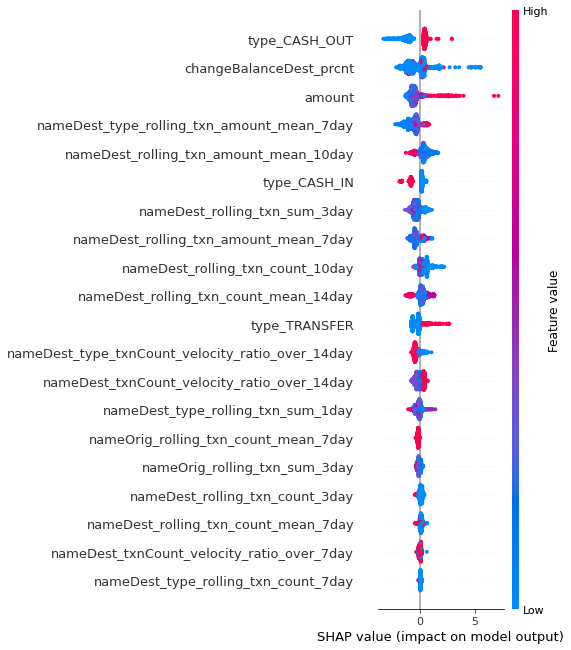

In [119]:
import shap

#all_features = np.delete(all_features, [0,1,2,3])

x_train = downsampled.drop(['step','isFraud'], axis=1).fillna(0)
#x_train = x_train[all_features]
y_train = downsampled[['isFraud']]

x_train_transform = pd.DataFrame(full_processor.fit_transform(x_train))
x_train_transform.columns = list(numerical_features) + categorical_transformed

#all_features = all_features[final_features]

xgb_model = xgboost.XGBClassifier(subsample=0.8, max_depth=15, learning_rate=0.3, objective= 'binary:logistic',n_jobs=-1,verbosity = 0)
#xgb_pipeline = Pipeline(steps=[('preprocess', full_processor), ('model', xgb_model)])
xgb_model.fit(x_train_transform[all_features], y_train)

model_input = pd.DataFrame(full_processor.fit_transform(x_test.fillna(0)))
model_input.columns = list(numerical_features) + categorical_transformed

shap_values = shap.TreeExplainer(xgb_model).shap_values(model_input[all_features])
shap.summary_plot(shap_values, model_input[all_features], max_display=20)#, plot_type="bar")


<a id='XGB_feature_importance'></a>
## 9. XGB feature importance

<Figure size 1600x960 with 0 Axes>

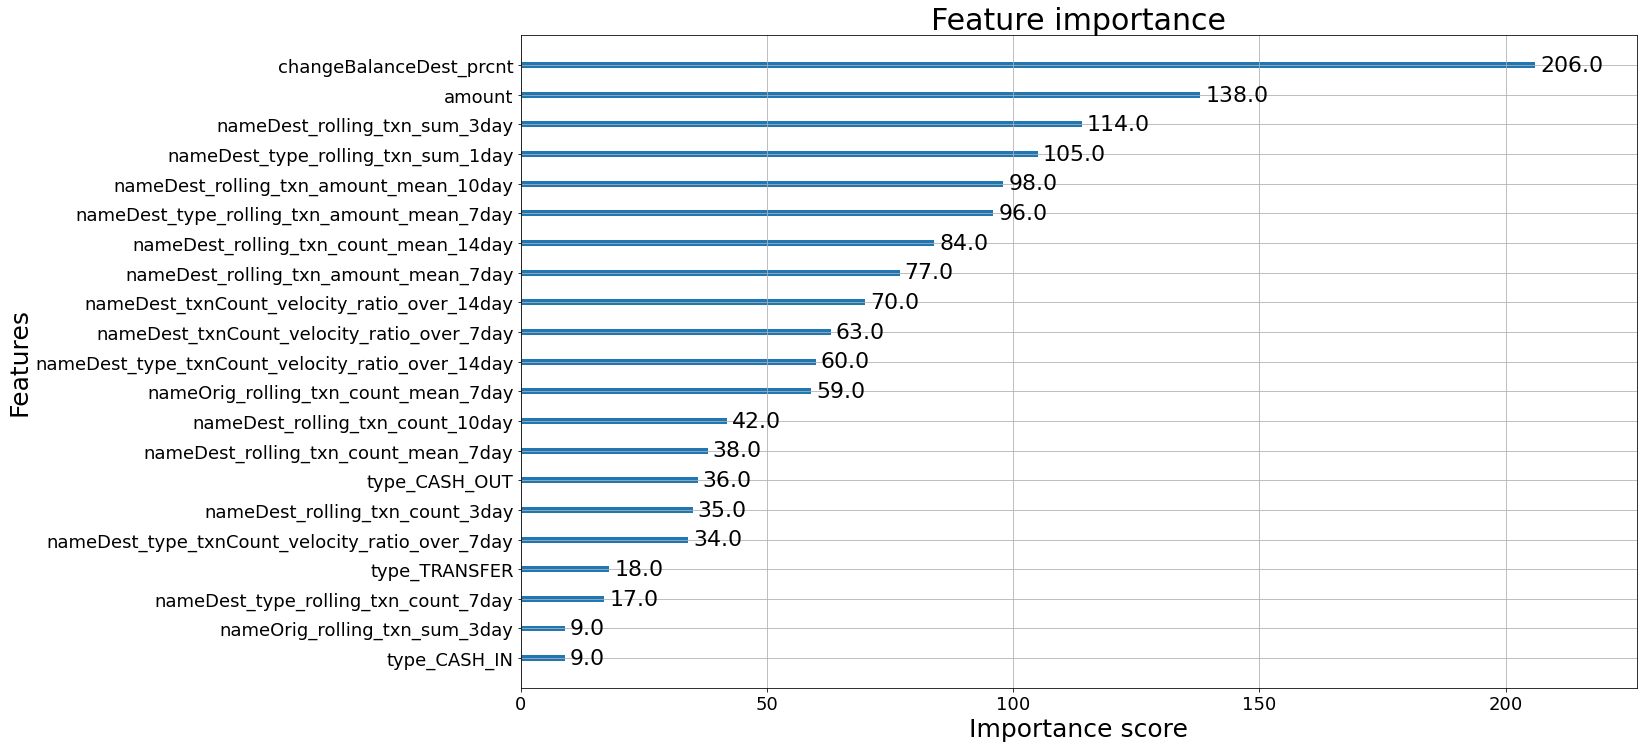

In [143]:
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.pyplot import figure

pyplot.rcParams.update({'font.size': 22})

pyplot.rcParams["figure.figsize"] = (20,12)
figure(figsize=(20, 12), dpi=80)

plot_importance(xgb_model)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Feature importance", fontsize=30)
plt.xlabel("Importance score", fontsize=25)
plt.ylabel("Features", fontsize=25)
pyplot.show()

In [121]:
len(x_train_transform.columns)

191

In [122]:
all_features

array(['type_CASH_IN', 'type_CASH_OUT', 'type_TRANSFER', 'amount',
       'nameOrig_rolling_txn_sum_3day', 'nameOrig_rolling_txn_sum_14day',
       'nameOrig_rolling_txn_count_mean_7day',
       'nameOrig_rolling_txn_amount_max_7day',
       'nameOrig_rolling_txn_amount_max_10day',
       'nameOrig_rolling_txn_amount_max_14day',
       'nameDest_rolling_txn_count_3day',
       'nameDest_rolling_txn_count_10day',
       'nameDest_rolling_txn_sum_3day',
       'nameDest_rolling_txn_count_mean_7day',
       'nameDest_rolling_txn_count_mean_14day',
       'nameDest_rolling_txn_amount_mean_7day',
       'nameDest_rolling_txn_amount_mean_10day',
       'nameOrig_type_rolling_txn_amount_max_7day',
       'nameOrig_type_rolling_txn_amount_max_10day',
       'nameDest_type_rolling_txn_count_7day',
       'nameDest_type_rolling_txn_sum_1day',
       'nameDest_type_rolling_txn_amount_mean_7day',
       'nameOrig_amount_max_velocity_ratio_over_10day',
       'nameDest_txnCount_velocity_ratio_over_

In [123]:
list(numerical_features) + categorical_transformed

['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'nameOrig_rolling_txn_count_1day',
 'nameOrig_rolling_txn_count_3day',
 'nameOrig_rolling_txn_count_7day',
 'nameOrig_rolling_txn_count_10day',
 'nameOrig_rolling_txn_count_14day',
 'nameOrig_rolling_txn_sum_1day',
 'nameOrig_rolling_txn_sum_3day',
 'nameOrig_rolling_txn_sum_7day',
 'nameOrig_rolling_txn_sum_10day',
 'nameOrig_rolling_txn_sum_14day',
 'nameOrig_rolling_txn_count_mean_7day',
 'nameOrig_rolling_txn_count_mean_10day',
 'nameOrig_rolling_txn_count_mean_14day',
 'nameOrig_rolling_txn_amount_mean_7day',
 'nameOrig_rolling_txn_amount_mean_10day',
 'nameOrig_rolling_txn_amount_mean_14day',
 'nameOrig_rolling_txn_amount_max_7day',
 'nameOrig_rolling_txn_amount_max_10day',
 'nameOrig_rolling_txn_amount_max_14day',
 'nameDest_rolling_txn_count_1day',
 'nameDest_rolling_txn_count_3day',
 'nameDest_rolling_txn_count_7day',
 'nameDest_rolling_txn_count_10day',
 'nameDest_rolling_txn_count_14day',


In [124]:
x_train_transform[all_features]

type_CASH_IN  type_CASH_OUT  type_TRANSFER      amount  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_sum_3day  nameDest_rolling_txn_count_mean_7day  nameDest_rolling_txn_count_mean_14day  nameDest_rolling_txn_amount_mean_7day  nameDest_rolling_txn_amount_mean_10day  nameOrig_type_rolling_txn_amount_max_7day  nameOrig_type_rolling_txn_amount_max_10day  nameDest_type_rolling_txn_count_7day  nameDest_type_rolling_txn_sum_1day  nameDest_type_rolling_txn_amount_mean_7day  nameOrig_amount_max_velocity_ratio_over_10day  nameDest_txnCount_velocity_ratio_over_7day  nameDest_txnCount_velocity_ratio_over_14day  nameDest_type_txnCount_velocity_ratio_over_7day  nameDest_type_txnCount_velocity_ratio_over_14day  nameOrig_had_prev_fraud  \
0            0.000          0.000          1.000  331545.250                     331545.250                      331545.250                                 1.000                            331545.250                             331545.250                             331545.250                           22.000                            22.000                    5820096.910                                22.000                                 22.000                            5820096.910                             5820096.910                                 331545.250                                  331545.250                                 3.000                         1035942.310                                 1035942.310                                          1.000                                       1.000                                        1.000                                            1.000                                             1.000                    0.000   
1            0.000          1.000          0.000    2806.000                       2806.000                        2806.000                                 1.000                              2806.000                               2806.000                               2806.000                            1.000                             1.000                       2806.000                                 1.000                                  1.000                               2806.000                                2806.000                                   2806.000                                    2806.000                                 1.000                            2806.000                                    2806.000                                          1.000                                       1.000                                        1.000                                            1.000                                             1.000                    0.000   
2            0.000          1.000          0.000  681093.570                     681093.570                      681093.570                                 1.000                            681093.570                             681093.570                             681093.570                           22.000                            22.000                    5820096.910                                22.000                                 22.000                            5820096.910                             5820096.910                                 681093.570                                  681093.570                                 8.000                         2144626.800                                 2144626.800                                          1.000                                       1.000                                        1.000                                            1.000                                             1.000                    0.000   
3     

In [125]:
#sample_ind = 20
#shap.plots.waterfall(shap_values[20], max_display=14)

In [126]:
model_input[all_features]

type_CASH_IN  type_CASH_OUT  type_TRANSFER     amount  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_sum_3day  nameDest_rolling_txn_count_mean_7day  nameDest_rolling_txn_count_mean_14day  nameDest_rolling_txn_amount_mean_7day  nameDest_rolling_txn_amount_mean_10day  nameOrig_type_rolling_txn_amount_max_7day  nameOrig_type_rolling_txn_amount_max_10day  nameDest_type_rolling_txn_count_7day  nameDest_type_rolling_txn_sum_1day  nameDest_type_rolling_txn_amount_mean_7day  nameOrig_amount_max_velocity_ratio_over_10day  nameDest_txnCount_velocity_ratio_over_7day  nameDest_txnCount_velocity_ratio_over_14day  nameDest_type_txnCount_velocity_ratio_over_7day  nameDest_type_txnCount_velocity_ratio_over_14day  nameOrig_had_prev_fraud  \
0            0.000          0.000          1.000  67277.540                      67277.540                       67277.540                                 0.006                             67277.540                              67277.540                              67277.540                            2.000                             2.000                     130533.950                                 0.012                                  0.006                                776.988                                 543.891                                  67277.540                                   67277.540                                 1.000                           67277.540                                     400.462                                          1.000                                      84.000                                      168.000                                          168.000                                           336.000                    0.000   
1            0.000          1.000          0.000  16508.840                      16508.840                       16508.840                                 0.006                             16508.840                              16508.840                              16508.840                            1.000                             1.000                      16508.840                                 0.006                                  0.003                                 98.267                                  68.787                                  16508.840                                   16508.840                                 1.000                           16508.840                                      98.267                                          1.000                                     168.000                                      336.000                                          168.000                                           336.000                    0.000   
2            0.000          0.000          1.000 493790.130                     493790.130                      493790.130                                 0.006                            493790.130                             493790.130                             493790.130                            1.000                             1.000                     493790.130                                 0.006                                  0.012                               2939.227                                2057.459                                 493790.130                                  493790.130                                 1.000                          493790.130                                    2939.227                                          1.000                                     168.000                                       84.000                                          168.000                                           168.000                    0.000   
3         

<a id='Model_explainability'></a>
## 10. Model explainability

In [127]:
#shap.plots.beeswarm(shap_values)

In [128]:
X5000 = shap.utils.sample(model_input[all_features], 5000)
explainer_ebm = shap.Explainer(xgb_model.predict, X5000)
shap_values_ebm = explainer_ebm(model_input[all_features])

Permutation explainer: 1376it [00:57, 19.35it/s]                                


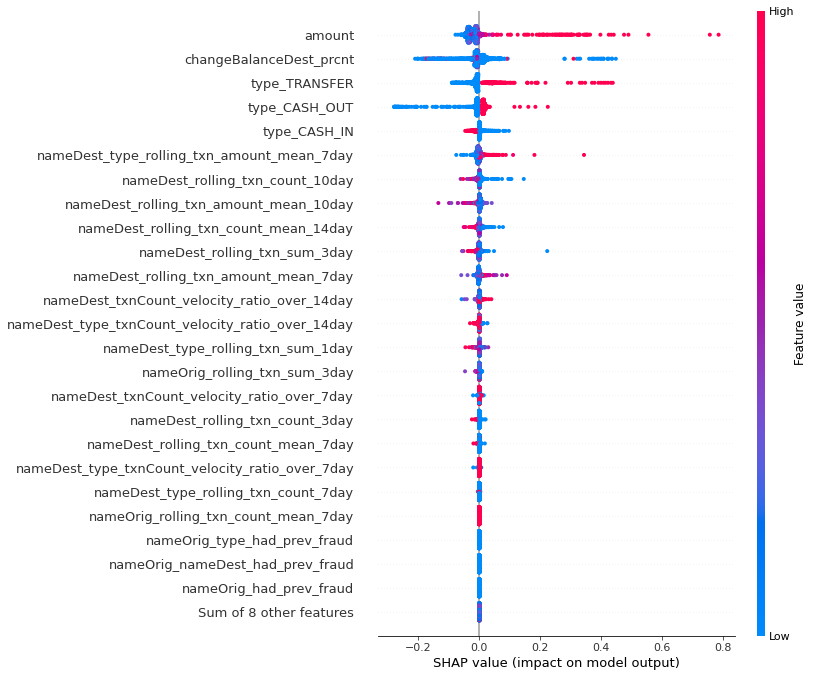

In [129]:
shap.plots.beeswarm(shap_values_ebm, max_display=25)

In [130]:
x_test = x_test.reset_index(drop=True)
x_test[['type','amount','nameOrig_had_prev_fraud','nameOrig_nameDest_had_prev_fraud','nameOrig_nameDest_type_had_prev_fraud']].iloc[34:35,]


type       amount  nameOrig_had_prev_fraud  nameOrig_nameDest_had_prev_fraud  nameOrig_nameDest_type_had_prev_fraud
34  CASH_OUT 10000000.000                    0.000                             0.000                                  0.000

In [131]:
model_input.iloc[34:35,]


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  nameDest_rolling_txn_sum_3day  \
34 10000000.000   10000000.000           0.000     2517892.180    12517892.180                            1.000                            1.000                            1.000                             1.000                             1.000                   10000000.000                   10000000.000                   10000000.000                    10000000.000                    10000000.000                                 0.006                                  0.004                                  0.003                              59523.810                               41666.667                               29761.905                          10000000.000                           10000000.000                           10000000.000                            1.000                            1.000                            1.000                             1.000                             2.000                   10000000.000                   10000000.000   

    nameDest_rolling_txn_sum_7day  nameDest_rolling_txn_sum_10day  nameDest_rolling_txn_sum_14day  nameDest_rolling_txn_count_mean_7day  nameDest_rolling_txn_count_mean_10day  nameDest_rolling_txn_count_mean_14day  nameDest_rolling_txn_amount_mean_7day  nameDest_rolling_txn_amount_mean_10day  nameDest_rolling_txn_amount_mean_14day  nameDest_rolling_txn_amount_max_7day  nameDest_rolling_txn_amount_max_10day  nameDest_rolling_txn_amount_max_14day  nameOrig_nameDest_rolling_txn_count_1day  nameOrig_nameDest_rolling_txn_count_3day  nameOrig_nameDest_rolling_txn_count_7day  nameOrig_nameDest_rolling_txn_count_10day  nameOrig_nameDest_rolling_txn_count_14day  nameOrig_nameDest_rolling_txn_sum_1day  nameOrig_nameDest_rolling_txn_sum_3day  nameOrig_nameDest_rolling_txn_sum_7day  nameOrig_nameDest_rolling_txn_sum_10day  nameOrig_nameDest_rolling_txn_sum_14day  nameOrig_nameDest_rolling_txn_count_mean_7day  nameOrig_nameDest_rolling_txn_count_mean_10day  \
34                   10000000.000                    10000000.000                    10337036.090                                 0.006                                  0.004                                  0.006                              59523.810                               41666.667                               30764.988                          10000000.000                           10000000.000                           10000000.000                                     1.000                                     1.000                                     1.000                                      1.000                                      1.000                            10000000.000                            10000000.000                            10000000.000                             10000000.000                             10000000.000                                          0.006                                           0.004   

    nameOrig_nameDest_rolling_txn_count_mean_14day  nameOrig_nameDest_rolling_txn_amount_mean_7day  nameOrig_name

In [132]:
#xgb_model.predict(model_input)

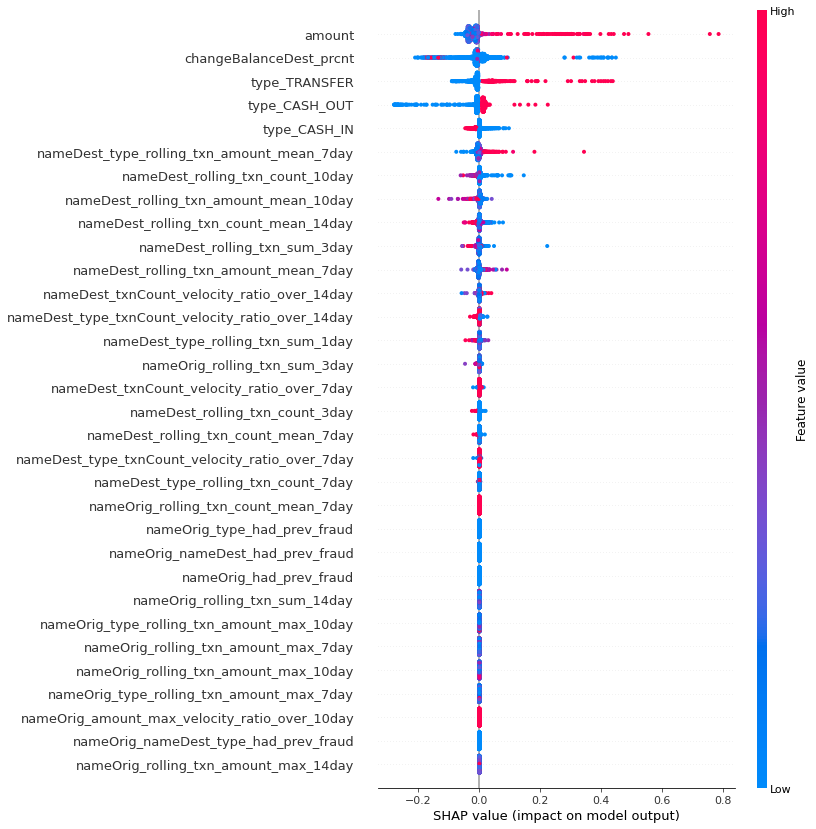

In [133]:
shap.plots.beeswarm(shap_values_ebm, max_display=33)

In [134]:
shap_values_ebm[34]

.values =
array([ 9.37500000e-03,  1.83750000e-01, -4.37500000e-03,  7.55625000e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.12500000e-03,
       -1.25000000e-03,  2.50000000e-03, -1.25000000e-03,  1.25000000e-03,
       -5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.30104261e-18,  4.68750000e-02,  0.00000000e+00, -6.25000000e-04,
       -3.75000000e-03,  0.00000000e+00, -1.25000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.50000000e-02])

.base_values =
0.04

.data =
array([0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+07,
       1.00000000e+07, 1.00000000e+07, 5.95238095e-03, 1.00000000e+07,
       1.00000000e+07, 1.00000000e+07, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+07, 5.95238095e-03, 5.95238095e-03, 5.95238095e+04,
       4.16666667e+04, 1.00000000e+07, 1.00000000e+07, 1.00000000e+00,
    

In [135]:
x_test.iloc[34:35,:][['amount','type','nameDest_rolling_txn_sum_14day','changeBalanceDest_prcnt','nameDest_rolling_txn_count_7day']]


amount      type  nameDest_rolling_txn_sum_14day  changeBalanceDest_prcnt  nameDest_rolling_txn_count_7day
34 10000000.000  CASH_OUT                    10337036.090                  397.157                            1.000

In [136]:
xgb_model.predict(model_input[all_features])[34]

1

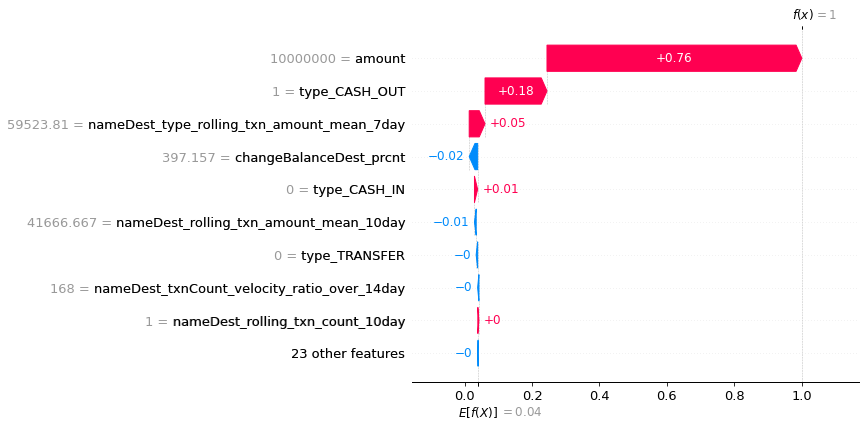

In [137]:
shap.plots.waterfall(shap_values_ebm[34])

In [138]:
shap_values_ebm

.values =
array([[ 0.      , -0.008125,  0.01875 , ...,  0.      ,  0.      ,
        -0.015   ],
       [ 0.      ,  0.01875 , -0.00875 , ...,  0.      ,  0.      ,
        -0.008125],
       [ 0.014375, -0.01625 ,  0.055   , ...,  0.      ,  0.      ,
        -0.098125],
       ...,
       [ 0.0025  ,  0.016875, -0.008125, ...,  0.      ,  0.      ,
        -0.015625],
       [-0.00875 , -0.00625 , -0.005625, ...,  0.      ,  0.      ,
         0.005   ],
       [ 0.080625,  0.160625, -0.004375, ...,  0.      ,  0.      ,
        -0.0475  ]])

.base_values =
array([0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04])

.data =
array([[ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , 14.69790549],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.75876314],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , 79.1801268 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        

In [139]:
y_test = y_test.reset_index(drop=True)
y_test[y_test['isFraud'] == 1]

isFraud
29          1
34          1
83          1
154         1
189         1
229         1
239         1
253         1
264         1
389         1
411         1
457         1
603         1
664         1
670         1
675         1
702         1
714         1
716         1
739         1
751         1
777         1
821         1
897         1
966         1
1008        1
1065        1
1081        1
1086        1
1177        1
1233        1
1247        1
1279        1
1374        1

In [141]:
test.iloc[34:35,]

step      type       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  nameOrig_rolling_txn_count_1day  nameOrig_rolling_txn_count_3day  nameOrig_rolling_txn_count_7day  nameOrig_rolling_txn_count_10day  nameOrig_rolling_txn_count_14day  nameOrig_rolling_txn_sum_1day  nameOrig_rolling_txn_sum_3day  nameOrig_rolling_txn_sum_7day  nameOrig_rolling_txn_sum_10day  nameOrig_rolling_txn_sum_14day  nameOrig_rolling_txn_count_mean_7day  nameOrig_rolling_txn_count_mean_10day  nameOrig_rolling_txn_count_mean_14day  nameOrig_rolling_txn_amount_mean_7day  nameOrig_rolling_txn_amount_mean_10day  nameOrig_rolling_txn_amount_mean_14day  nameOrig_rolling_txn_amount_max_7day  nameOrig_rolling_txn_amount_max_10day  nameOrig_rolling_txn_amount_max_14day  nameDest_rolling_txn_count_1day  nameDest_rolling_txn_count_3day  nameDest_rolling_txn_count_7day  nameDest_rolling_txn_count_10day  nameDest_rolling_txn_count_14day  nameDest_rolling_txn_sum_1day  \
2582   718  CASH_OUT 10000000.000   10000000.000           0.000     2517892.180    12517892.180        1                            1.000                            1.000                            1.000                             1.000                             1.000                   10000000.000                   10000000.000                   10000000.000                    10000000.000                    10000000.000                                 0.006                                  0.004                                  0.003                              59523.810                               41666.667                               29761.905                          10000000.000                           10000000.000                           10000000.000                            1.000                            1.000                            1.000                             1.000                             2.000                   10000000.000   

      nameDest_rolling_txn_sum_3day  nameDest_rolling_txn_sum_7day  nameDest_rolling_txn_sum_10day  nameDest_rolling_txn_sum_14day  nameDest_rolling_txn_count_mean_7day  nameDest_rolling_txn_count_mean_10day  nameDest_rolling_txn_count_mean_14day  nameDest_rolling_txn_amount_mean_7day  nameDest_rolling_txn_amount_mean_10day  nameDest_rolling_txn_amount_mean_14day  nameDest_rolling_txn_amount_max_7day  nameDest_rolling_txn_amount_max_10day  nameDest_rolling_txn_amount_max_14day  nameOrig_nameDest_rolling_txn_count_1day  nameOrig_nameDest_rolling_txn_count_3day  nameOrig_nameDest_rolling_txn_count_7day  nameOrig_nameDest_rolling_txn_count_10day  nameOrig_nameDest_rolling_txn_count_14day  nameOrig_nameDest_rolling_txn_sum_1day  nameOrig_nameDest_rolling_txn_sum_3day  nameOrig_nameDest_rolling_txn_sum_7day  nameOrig_nameDest_rolling_txn_sum_10day  nameOrig_nameDest_rolling_txn_sum_14day  nameOrig_nameDest_rolling_txn_count_mean_7day  nameOrig_nameDest_rolling_txn_count_mean_10day  \
2582                   10000000.000                   10000000.000                    10000000.000                    10337036.090                                 0.006                                  0.004                                  0.006                              59523.810                               41666.667                               30764.988                          10000000.000                           10000000.000                           10000000.000                                     1.000                                     1.000                                     1.000                                      1.000                                      1.000                            10000000.000                            10000000.000                            10000000.000                             10000000.000                             10000000.000                                          0.006                                           0.004   

      nameOrig_nameDest_rolling_txn_count_mean_14day

### Appendix

explained variance ratio (first two components): [0.71268147 0.16490853]


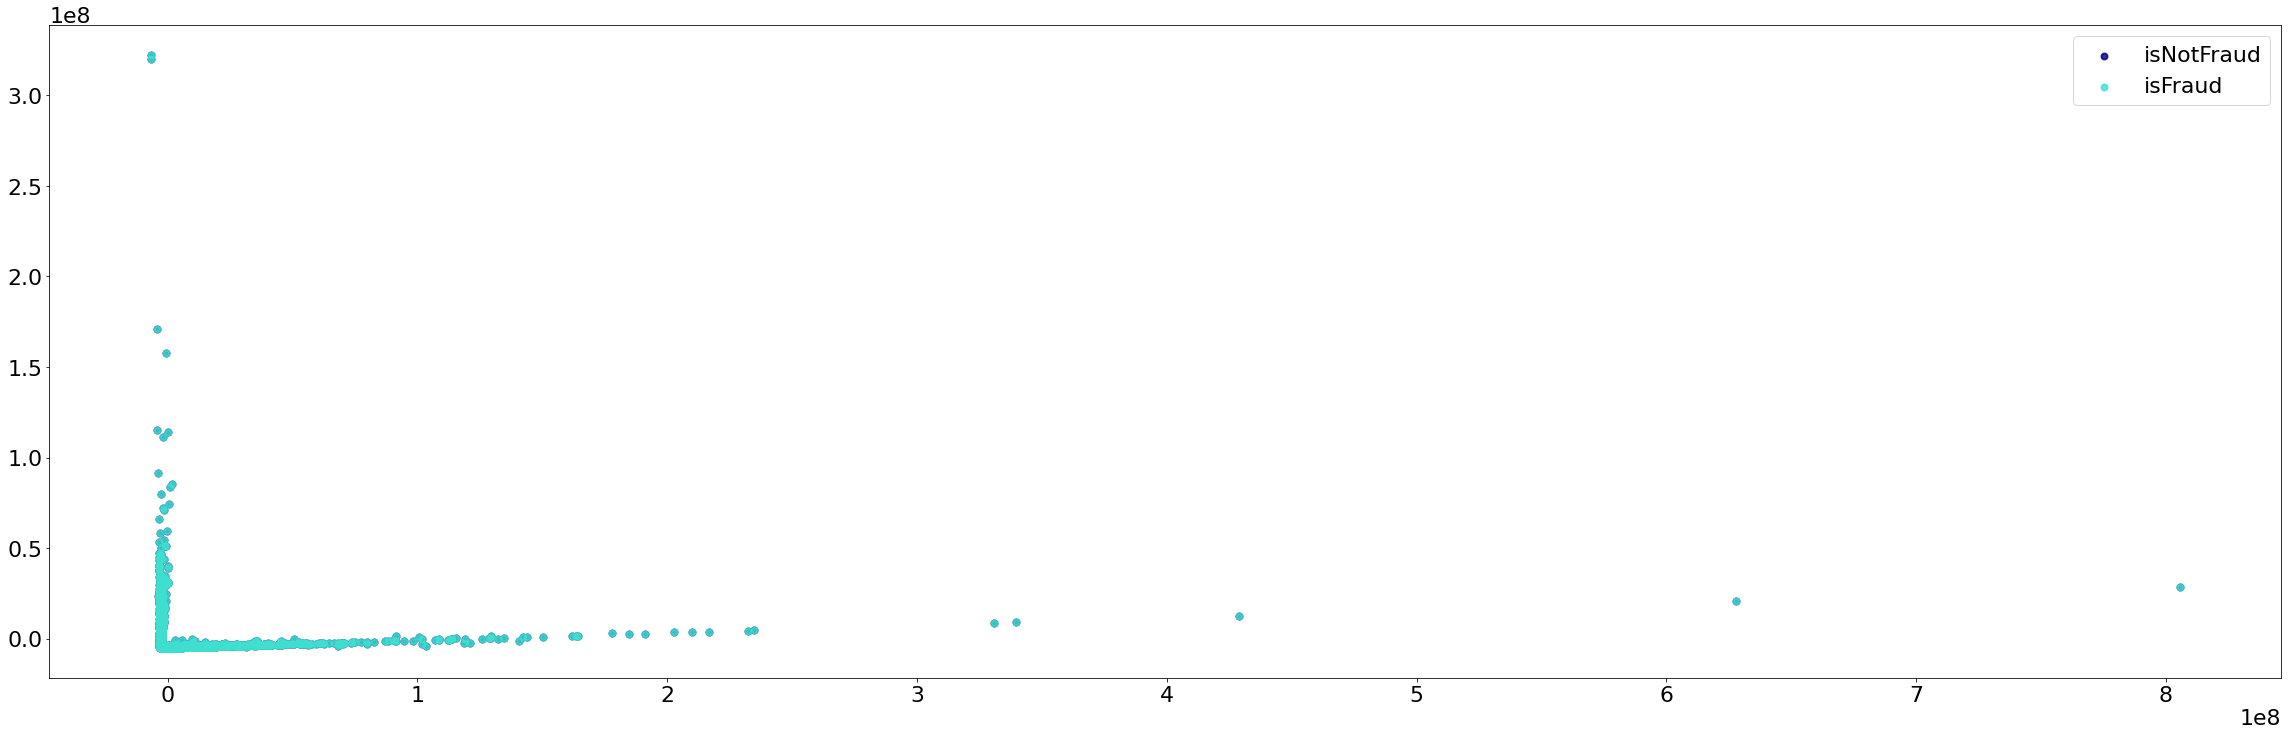

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook

pyplot.rcParams["figure.figsize"] = (40,12)

X = x_train_transform
y = y_train
target_names = ['isNotFraud','isFraud']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[:,0], X_r[:,1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)

### End